## **Imports & Shared Functions**

*   Generate a download URL and handle file downloads




In [1]:
!pip install yfinance
import plotly.graph_objects as go
import yfinance as yf

import pandas as pd
import datetime
import urllib.request
import datetime
import os
import time
import json
from IPython.display import display, HTML

def generate_download_url(symbol, start_date, end_date=None):
    if end_date is None:
        end_date = datetime.datetime.now().strftime('%Y/%m/%d')
    url = f"https://fastquote.fidelity.com/service/marketdata/historical/chart/json?productid=oce&symbols={symbol}&startDate={start_date}&endDate={end_date}&barWidth=DAILY&extendedHours=N&quoteType=R&corpActions=N&timestamp=start&uuid=eeca8878de7c0b11d6b90f9bc8b54aaa77&usecache=y&callback=jQuery"
    return url

def download_and_save(url, filename, retries=3, delay=5):
    for attempt in range(retries):
        try:
            # Download the file
            urllib.request.urlretrieve(url, filename)
            print(f"File downloaded and saved as {filename}")
            return
        except Exception as e:
            print(f"Error: {e}")
            if attempt < retries - 1:
                print("Retrying...")
                time.sleep(delay)
    print(f"Failed to download file after {retries} attempts.")

def remove_jquery_tag(symbol):
    filename = f"{symbol}.json"
    # Read the content from the file
    with open(filename, 'r') as file:
        content = file.read()
    # Remove the jQuery wrapper
    content = content.replace('jQuery(', '').replace(')', '')
    # Write the cleaned content back to the file
    with open(filename, 'w') as file:
        file.write(content)


def parse_json_file(symbol):
    filename = f"{symbol}.json"
    with open(filename, 'r') as file:
        data = json.load(file)

    # Extract the main data
    symbol_info = data['Symbol'][0]
    # Extract the bar records
    bar_records = symbol_info['BarList']['BarRecord']
    bar_df = pd.DataFrame(bar_records)
    # Save DataFrames to CSV
    filename = f"{symbol}.csv"
    bar_df.to_csv(filename, index=False)

    print(f"CSV file {filename} have been created.")


def color_display(text, color = 'green'):
  # HTML string for bold and large green text
  html_string = f"""
  <div style="color: {color}; font-weight: bold; font-size: 24px;">
    {text}
  </div>
  """
  # Display the HTML
  display(HTML(html_string))





[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


##  **Download Data**

*   Handle multiple downloads and extract the symbols and filenames.
*   Use the **SPY** and **XYLD** pair.

In [2]:
symbols = [
    'SPY',
    'XYLD'
]
filenames = []

# Start date for all downloads
start_date = '2013/06/01'

# Loop through each item in the list and perform download
for symbol in symbols:
    url = generate_download_url(symbol, start_date)
    filename = f"{symbol}.json"
    download_and_save(url, filename)
    remove_jquery_tag(symbol)
    parse_json_file(symbol)
    filename = f"{symbol}.csv"
    filenames.append(filename)
    time.sleep(2)  # Optional: Additional delay between requests to avoid rate limits



File downloaded and saved as SPY.json
CSV file SPY.csv have been created.
File downloaded and saved as XYLD.json
CSV file XYLD.csv have been created.


## **Combine Data**
*   Reads historical stock data for two symbols from CSV files.
*   Aligns the data by date and generates a new CSV file containing the adjusted closing prices for both symbols on the corresponding dates.
*   The resulting file is then loaded and the data is displayed

In [3]:
import pandas as pd

# Read the CSV files
df_symbol0 = pd.read_csv(filenames[0])
df_symbol1 = pd.read_csv(filenames[1])

# Ensure the 'lt' column is in datetime format
df_symbol0['lt'] = pd.to_datetime(df_symbol0['lt'])
df_symbol1['lt'] = pd.to_datetime(df_symbol1['lt'])

# Create an empty list to collect results
results_list = []

# Iterate through each row in df_symbol0
for index, row in df_symbol0.iterrows():
    date = row['lt']
    price0 = row['cl']

    # Find matching date in df_symbol1
    matching_row = df_symbol1[df_symbol1['lt'] == date]

    if not matching_row.empty:
        price1 = matching_row['cl'].values[0]
        results_list.append({'Date': date, symbols[0]: price0, symbols[1]: price1})

# Convert the list to a DataFrame
results = pd.DataFrame(results_list)
results.to_csv('data.csv', index=False)
print(f"File saved")

df = pd.read_csv('data.csv')
print(df.head())

File saved
         Date      SPY   XYLD
0  2013-06-24  157.060  39.75
1  2013-06-25  158.575  39.83
2  2013-06-26  160.140  40.30
3  2013-06-27  161.080  40.51
4  2013-06-28  160.420  40.45


## **Correlation**

                  SPY      XYLD  SPY_Change  XYLD_Change
SPY          1.000000 -0.181695    0.019284     0.005234
XYLD        -0.181695  1.000000    0.030686     0.052649
SPY_Change   0.019284  0.030686    1.000000     0.853683
XYLD_Change  0.005234  0.052649    0.853683     1.000000
Correlation between the daily changes between SPY and XYLD: 0.8536830658892361


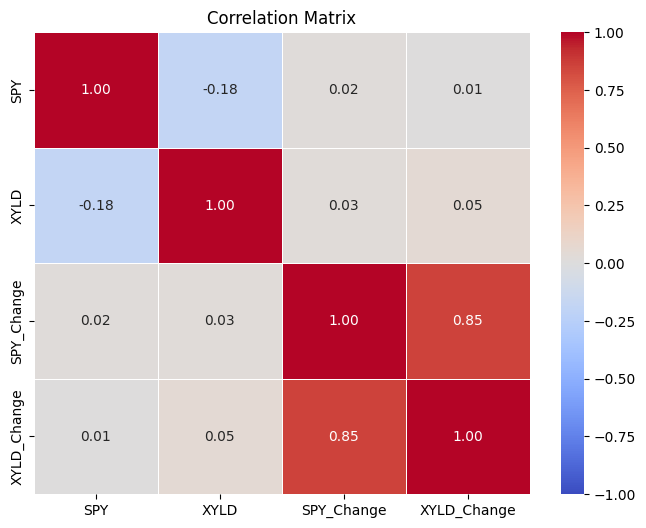

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate daily changes
df[f'{symbols[0]}_Change'] = df[f'{symbols[0]}'].diff()/df[f'{symbols[0]}']
df[f'{symbols[1]}_Change'] = df[f'{symbols[1]}'].diff()/df[f'{symbols[1]}']

# Calculate the correlation matrix
corr_matrix = df.corr(numeric_only=True)
print(corr_matrix)

# Calculate correlation
correlation = df[f'{symbols[0]}_Change'].corr(df[f'{symbols[1]}_Change'])
print(f'Correlation between the daily changes between {symbols[0]} and {symbols[1]}: {correlation}')

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f', linewidths=0.5)

plt.title('Correlation Matrix')
plt.show()



## **Calculate Rate of Change**
### processes historical stock data by:

1.   Shifting specified columns downward by a defined number of days
2.   Calculating the Rate of Change (ROC) for these columns
3.   Computing the difference between the ROC values of two columns
4.   Saving the resulting DataFrame to a CSV file

File saved
Mean of ROC_diff: 0.0106
Standard Deviation of ROC_diff: 0.0193


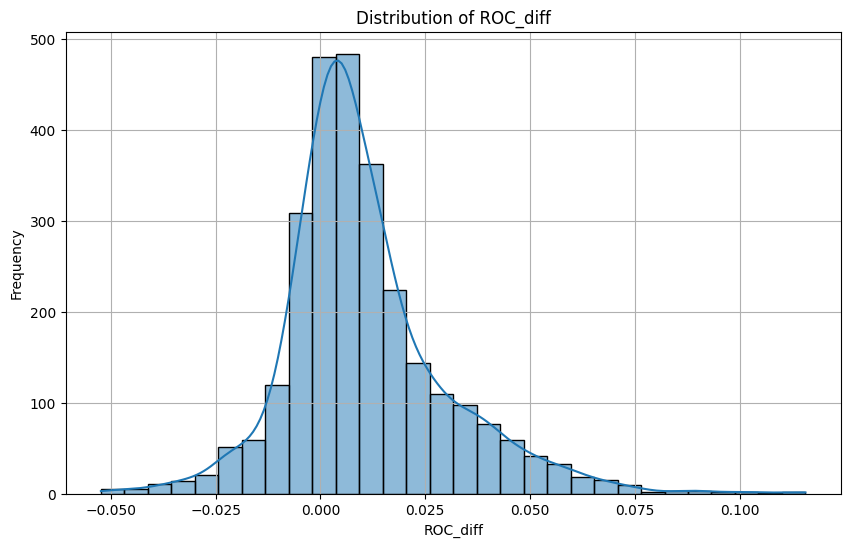

In [5]:
LOOKBACK_DAY = 23

def shift_and_fill(df, column_names, shift_down_value):
  for column_name in column_names:
    df[column_name + '_shifted'] = df[column_name].shift(shift_down_value)
  return df

def calculate_roc(df, column_names):
  for column_name in column_names:
    df[column_name + '_ROC'] = (df[column_name] - df[column_name + '_shifted']) / df[column_name + '_shifted']
  return df


df_shifted = shift_and_fill(df.copy(), [symbols[0], symbols[1]], LOOKBACK_DAY)
df_shifted = calculate_roc(df_shifted, [symbols[0], symbols[1]])
df_shifted['ROC_diff'] = df_shifted[symbols[0] + '_ROC'] - df_shifted[symbols[1] + '_ROC']

df_shifted.to_csv('processed_data.csv', index=False)
print(f"File saved")

# Calculate mean and standard deviation of 'ROC_diff'
mean_roc_diff = df_shifted['ROC_diff'].mean()
std_roc_diff = df_shifted['ROC_diff'].std()

print(f"Mean of ROC_diff: {mean_roc_diff:.4f}")
print(f"Standard Deviation of ROC_diff: {std_roc_diff:.4f}")

# Plotting the distribution of 'ROC_diff'
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(df_shifted['ROC_diff'].dropna(), kde=True, bins=30)
plt.title('Distribution of ROC_diff')
plt.xlabel('ROC_diff')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## **Simulating Trades**

*   Performs a backtest of a trading strategy based on the Rate of Change (ROC) indicator's difference

**Entry Criteria:**
> *   *Buy when the ROC difference falls below the buy threshold*

**Exit Criteria:**
> *   *Sell if the holding period surpasses the maximum number of position days.*
> *   *Sell if the price rises by more than the target percentage from the entry price.*


In [6]:
BUY_THREAHOLD = -0.004
SELL_TARGET = 0.05
MAX_POSITION_DAY = 10

def backtest(df, buy_threshold, sell_target, max_position_day=10):
    has_position = False
    position_days = 0
    entry_price = 0
    trades = []
    trade_num = 1

    for index, row in df.iterrows():
        roc_diff = row['ROC_diff']
        price = row[symbols[0]]
        date = row['Date']
        is_buy_signal = (roc_diff < buy_threshold)

        if not has_position:
            if is_buy_signal:
                has_position = True
                position_days = 1
                entry_price = price
                trades.append((trade_num, 'BUY', date, price))
        else:  # has_position is True
            position_days += 1
            exit_position = False
            if position_days >= max_position_day:
                exit_position = True
            elif price > entry_price * (1 + sell_target):
                exit_position = True

            if exit_position:
                has_position = False
                position_days = 0
                entry_price = 0
                trades.append((trade_num, 'SELL', date, price))
                trade_num += 1

    return trade_num - 1, trades


trade_num, trades = backtest(df_shifted, BUY_THREAHOLD, SELL_TARGET, MAX_POSITION_DAY)
print("Trade Number:", trade_num)
print("Trades:", trades)



Trade Number: 104
Trades: [(1, 'BUY', '2013-08-23', 166.62), (1, 'SELL', '2013-09-06', 166.04), (2, 'BUY', '2013-10-07', 167.43), (2, 'SELL', '2013-10-18', 174.388), (3, 'BUY', '2013-10-22', 175.41), (3, 'SELL', '2013-11-04', 176.83), (4, 'BUY', '2014-01-30', 179.23), (4, 'SELL', '2014-02-12', 182.07), (5, 'BUY', '2014-02-13', 183.01), (5, 'SELL', '2014-02-27', 185.82), (6, 'BUY', '2014-04-07', 184.34), (6, 'SELL', '2014-04-21', 187.04), (7, 'BUY', '2014-08-05', 192.01), (7, 'SELL', '2014-08-20', 198.92), (8, 'BUY', '2014-09-30', 197.02), (8, 'SELL', '2014-10-13', 187.4099), (9, 'BUY', '2014-10-22', 192.69), (9, 'SELL', '2014-11-05', 202.34), (10, 'BUY', '2015-01-30', 199.45), (10, 'SELL', '2015-02-12', 208.92), (11, 'BUY', '2015-03-24', 208.82), (11, 'SELL', '2015-04-07', 207.28), (12, 'BUY', '2015-04-08', 207.975), (12, 'SELL', '2015-04-21', 209.6), (13, 'BUY', '2015-05-07', 208.87), (13, 'SELL', '2015-05-20', 212.88), (14, 'BUY', '2015-06-02', 211.36), (14, 'SELL', '2015-06-16', 210

## **Calculate Performance Metrics**


* **Total Trades**: Total number of trades (both profitable and loss).
* **Win Rate**: Ratio of profitable trades to total trades.
* **Gross Profit**: Total amount of profit from all profitable trades.
* **Gross Loss**: Total amount of loss from all losing trades.
* **Profit Factor**: Ratio of gross profit to gross loss, representing the efficiency of the trading strategy.



In [7]:
def analyze_trades(trades, amount = 10000):
    # Convert to DataFrame
    trades_df = pd.DataFrame(trades, columns=['Trade_Num', 'Action', 'Date', 'Price'])
    trades_df.to_csv('trade_data.csv', index=False)
    # Initialize lists to store profits and losses
    profits = []
    losses = []
    profit_percents = []
    trade_list = []

    # Iterate over trades and calculate profits and losses
    for trade_num, group in trades_df.groupby('Trade_Num'):
        if len(group) == 2:  # Ensure there is a BUY and SELL
            buy_date = group.loc[group['Action'] == 'BUY', 'Date'].values[0]
            buy_price = group.loc[group['Action'] == 'BUY', 'Price'].values[0]
            sell_date = group.loc[group['Action'] == 'SELL', 'Date'].values[0]
            sell_price = group.loc[group['Action'] == 'SELL', 'Price'].values[0]

            # Calculate shares
            shares = 100
            amount = sell_price * shares

            # Calculate profit or loss
            profit = (sell_price - buy_price) * shares
            if profit > 0:
                profits.append(profit)
            else:
                losses.append(abs(profit))

            # Calculate profit percent
            profit_percent = (sell_price - buy_price) / buy_price
            profit_percents.append(profit_percent)

            # Add to trade list
            trade_list.append((buy_date, f"${buy_price:,.2f}", shares, sell_date, f"${sell_price:,.2f}", f"${profit:,.2f}", f"{profit_percent:.2%}"))

    # Calculate win rate
    total_trades = len(profits) + len(losses)
    win_rate = len(profits) / total_trades if total_trades > 0 else 0

    # Calculate profit factor
    gross_profit = sum(profits)
    gross_loss = sum(losses)
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')

    return {
        'Total Trades': total_trades,
        'Gross Profit': f"${gross_profit:.2f}",
        'Gross Loss': f"${gross_loss:.2f}",
        'Win Rate': f"{win_rate:.2%}",
        'Profit Factor': f"{profit_factor:.2f}"
    }, trade_list

# Analyze trades
results, trade_list = analyze_trades(trades)
print("Analysis Results:")
print(f"Total Trades: {results['Total Trades']}")
print(f"Gross Profit: {results['Gross Profit']}")
print(f"Gross Loss: {results['Gross Loss']}")
print(f"Profit Factor: {results['Profit Factor']}")
print(f"Win Rate: {results['Win Rate']}")
trans = pd.DataFrame(trade_list, columns=['Buy Date', 'Buy Price', 'Shares', 'Sell Date', 'Sell Price', 'Profit', 'Profit Percent'])
trans.to_csv('trans_data.csv', index=True)


Analysis Results:
Total Trades: 104
Gross Profit: $63562.30
Gross Loss: $20839.45
Profit Factor: 3.05
Win Rate: 72.12%


## **Equity Curve and Annualized Rate of Return (ARR)**
* **Calculates the Equity Curve**: Tracks the portfolio value over time based on buy and sell trades.
* **Computes ARR**: Measures the annualized return of the trading strategy.
* **Displays Results**: Prints the ARR and trading symbols.
* **Visualizes the Equity Curve**: Plots the portfolio value over time to show how the value evolves with the trading strategy.

End Value: 36608.20649999999


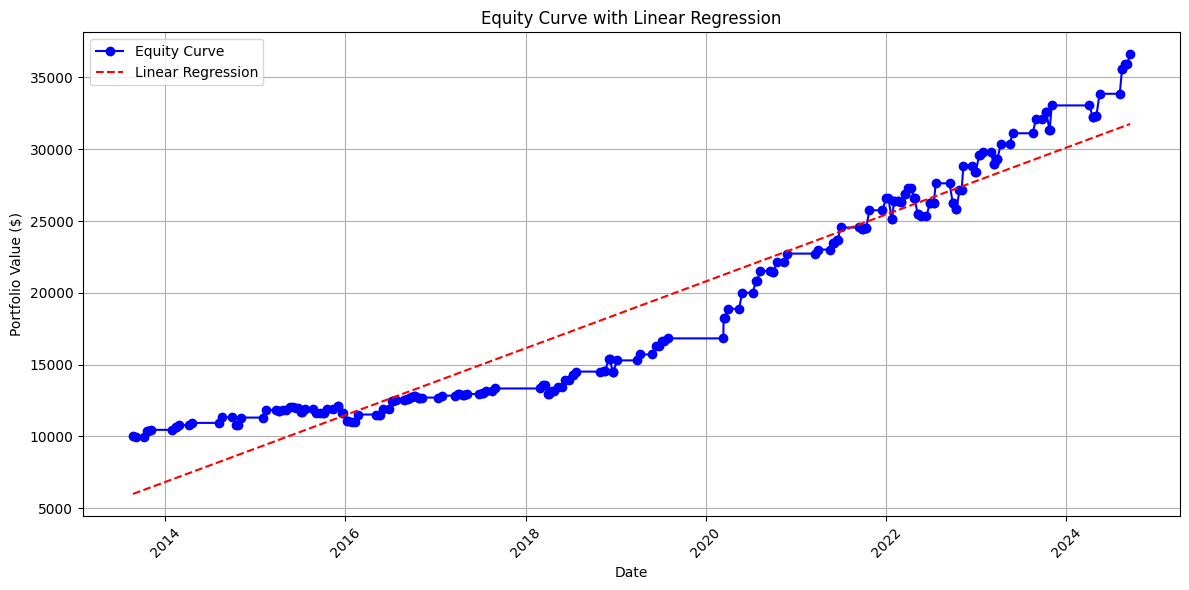

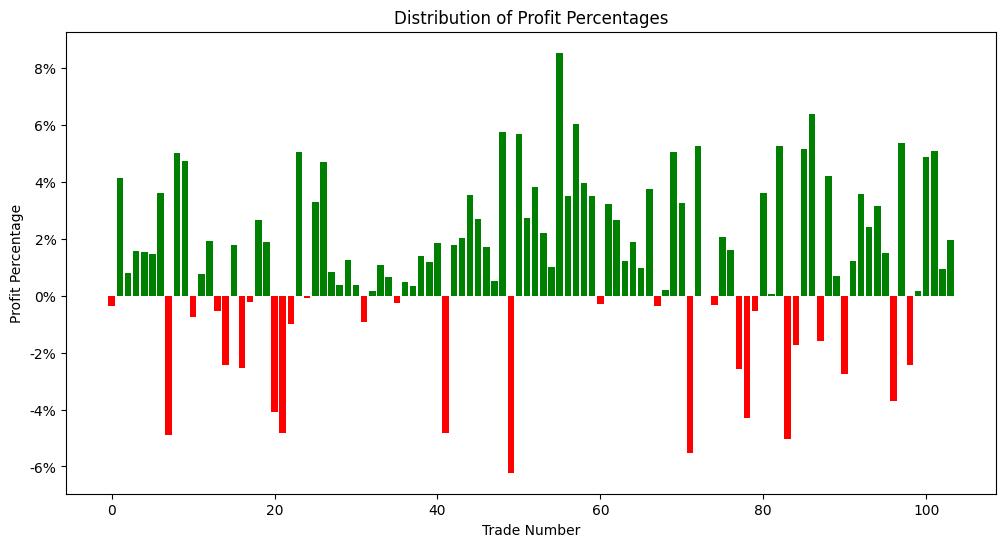

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

def calculate_equity_curve(trades, initial_amount=10000):
    trades_df = pd.DataFrame(trades, columns=['Trade_Num', 'Action', 'Date', 'Price'])
    trades_df['Date'] = pd.to_datetime(trades_df['Date'])
    trades_df.sort_values(by='Date', inplace=True)

    portfolio_value = initial_amount
    equity_curve = []
    current_shares = 0
    current_cash = initial_amount

    for index, row in trades_df.iterrows():
        if row['Action'] == 'BUY':
            buy_price = row['Price']
            shares_to_buy = current_cash // buy_price
            cost = shares_to_buy * buy_price
            current_cash -= cost
            current_shares += shares_to_buy
        elif row['Action'] == 'SELL':
            sell_price = row['Price']
            cash_from_sale = current_shares * sell_price
            current_cash += cash_from_sale
            current_shares = 0

        portfolio_value = current_cash + (current_shares * row['Price'])
        equity_curve.append({'Date': row['Date'], 'Portfolio_Value': portfolio_value})

    equity_curve_df = pd.DataFrame(equity_curve)
    return equity_curve_df

def calculate_arr(equity_curve_df, initial_amount=10000):
    start_value = initial_amount
    end_value = equity_curve_df['Portfolio_Value'].iloc[-1]
    print("End Value:", end_value)

    # Calculate total return
    total_return = (end_value - start_value) / start_value

    # Calculate the number of years in the period
    start_date = equity_curve_df['Date'].iloc[0]
    end_date = equity_curve_df['Date'].iloc[-1]
    num_years = (end_date - start_date).days / 365.25

    # Calculate ARR (Annualized Rate of Return)
    arr = (1 + total_return) ** (1 / num_years) - 1

    # Calculate annual returns grouped by year
    equity_curve_df['Year'] = equity_curve_df['Date'].dt.year
    annual_returns = equity_curve_df.groupby('Year').apply(
        lambda df: (df['Portfolio_Value'].iloc[-1] - df['Portfolio_Value'].iloc[0]) / df['Portfolio_Value'].iloc[0]
    ).reset_index(name='Annual_Return')

    return arr, annual_returns

def perform_linear_regression(equity_curve_df):
    equity_curve_df['Date_Ordinal'] = equity_curve_df['Date'].map(pd.Timestamp.toordinal)
    X = equity_curve_df[['Date_Ordinal']].values
    y = equity_curve_df['Portfolio_Value'].values

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    return y_pred

def plot_trade_profit_percentage():
  # Load transaction data
  trans = pd.read_csv('trans_data.csv')

  # Extract profit percentages and convert to numeric
  trans['Profit Percent'] = trans['Profit Percent'].str.rstrip('%').astype('float') / 100
  avg_profit = trans[trans['Profit Percent'] > 0]['Profit Percent'].mean()
  avg_loss = trans[trans['Profit Percent'] < 0]['Profit Percent'].mean()

  # Create a bar chart of profit percentages
  plt.figure(figsize=(12, 6))
  colors = ['red' if p < 0 else 'green' for p in trans['Profit Percent']]
  plt.bar(trans.index, trans['Profit Percent'], color=colors)
  # Add horizontal lines for average profit and loss
  # plt.axhline(avg_profit, color='g', linestyle='--', linewidth=1, label='Average Profit')
  # plt.axhline(avg_loss, color='r', linestyle='--', linewidth=1, label='Average Loss')

  # Add labels and title
  plt.xlabel('Trade Number')
  plt.ylabel('Profit Percentage')
  plt.title('Distribution of Profit Percentages')

  # Format y-axis as percentages
  plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

  # Display the chart
  plt.show()

  return avg_profit, avg_loss

def draw_stock_chart(symbol, start_date):
    ticker = yf.Ticker(symbol) 
    end_date = pd.Timestamp.today(tz='America/New_York').ceil('D')
    start_date = pd.to_datetime(start_date)
    data = ticker.history(start=start_date,end=end_date, interval='1d').reset_index()

    # Plot as a line chart
    fig = go.Figure(data=go.Scatter(
            x=data.Date,
            y=data.Close,
            mode='lines'
    ))
    fig.update_layout( 
        title=symbol,
        title_x=0.5,
        autosize=True,
    )
    fig.show()

# Calculate equity curve
equity_curve_df = calculate_equity_curve(trades)

# Calculate ARR
apr, annual_returns = calculate_arr(equity_curve_df)
color_display(f"{symbols[0]}/{symbols[1]}")
color_display(f"ARR: {apr:.2%}", 'green')

# Prepare data for linear regression
y_pred = perform_linear_regression(equity_curve_df)

# Plot equity curve and linear regression line
plt.figure(figsize=(12, 6))
plt.plot(equity_curve_df['Date'], equity_curve_df['Portfolio_Value'], marker='o', linestyle='-', color='b', label='Equity Curve')
plt.plot(equity_curve_df['Date'], y_pred, linestyle='--', color='r', label='Linear Regression')

# Add titles and labels
plt.title('Equity Curve with Linear Regression')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot stock chart
start_date = equity_curve_df['Date'].iloc[0]
draw_stock_chart(symbols[0], start_date)

# Plot trade profit percentage
avg_profit, avg_loss = plot_trade_profit_percentage()
color_display(f"Average Profit %: {avg_profit:.2%}", 'green')
color_display(f"Average Loss %: {avg_loss:.2%}", 'green')



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a1dba5c8-7531-4272-828d-1fa518690a99' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>